In [32]:
# basic packages
import pandas as pd
import numpy as np
import warnings
from calendar import day_abbr

# visualization
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from plotly import graph_objs as go
from plotly.subplots import make_subplots
from plotly.graph_objs import *

# FB prophet for time series
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

# some udf's
import funcs as f

%matplotlib inline

In [50]:
warnings.filterwarnings('ignore')
mapbox_access_token = "pk.eyJ1IjoicGxvdGx5bWFwYm94IiwiYSI6ImNqdnBvNDMyaTAxYzkzeW5ubWdpZ2VjbmMifQ.TXcBE-xg9BFdV2ocecc_7g"

In [7]:
# importing saved data

df = pd.read_csv('./data/processed/combined.csv')
df_citi = pd.read_csv('./data/citi/combined.csv').drop(columns = ['Unnamed: 0'])

df = df.append(df_citi)
df['starttime'] = pd.to_datetime(df['starttime'], format = '%Y-%m-%d %H:%M')
df['stoptime'] = pd.to_datetime(df['stoptime'], format = '%Y-%m-%d %H:%M')

df = df.set_index('starttime')

In [56]:
# gender and age

df.loc[df['gender'] == 0, 'gender'] = 'unknown'
df.loc[df['gender'] == 1, 'gender'] = 'male'
df.loc[df['gender'] == 2, 'gender'] = 'female'

df['age'] = df.index.year - df['birth_year'] + 1

# Age and Gender Demos

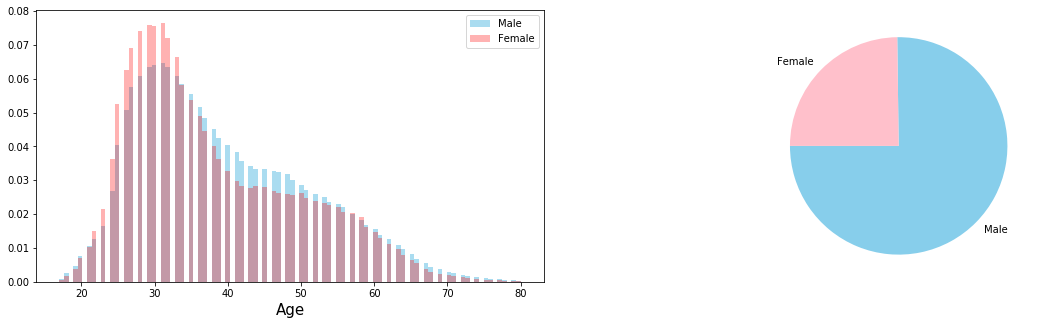

In [9]:
mask = (df['age'] <= 80) & (df['gender'] != 'unknown')

# historgrams
m = df[mask & (df['gender'] == 'male')]['age']
f = df[mask & (df['gender'] == 'female')]['age']

# pie chart
dat = df[mask].gender.value_counts(normalize = True)

# figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))

ax1.hist(m, bins = 100, alpha = 0.7, color = 'skyblue', label = 'Male', density = True)
ax1.hist(f, bins = 100, alpha = 0.3, color = 'red', label = 'Female', density = True)
ax1.set_xlabel('Age', fontsize = 15)
ax1.legend(loc = 'upper right')

ax2.pie(dat.values, labels = ['Male', 'Female'], startangle = 180, colors = ['skyblue', 'pink']);

# Usgage Trends

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


<Figure size 432x288 with 0 Axes>

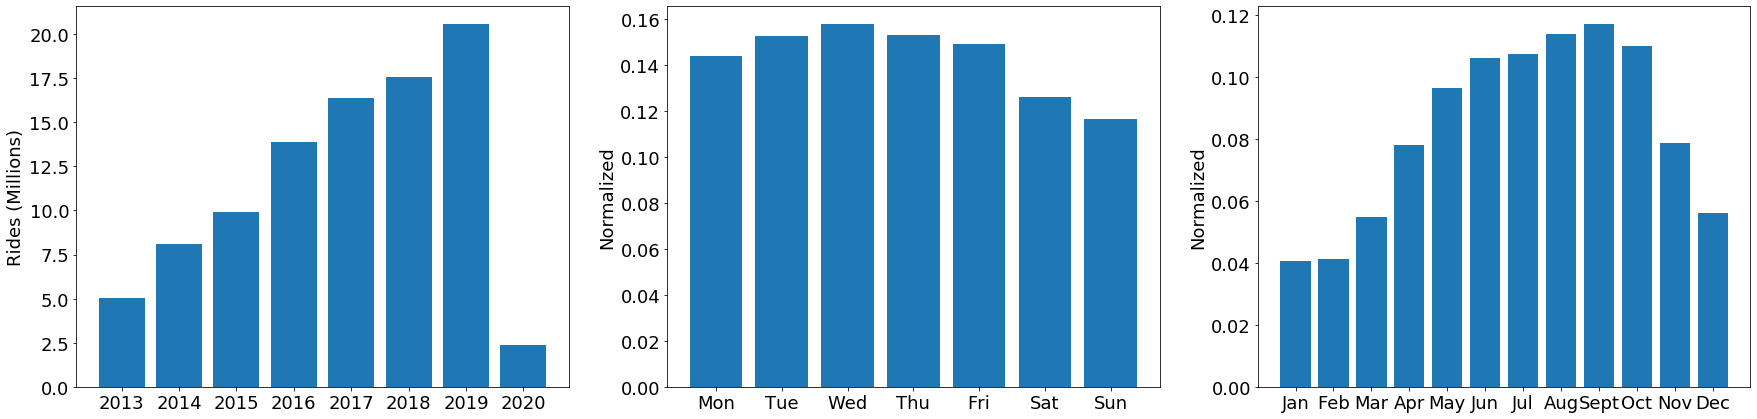

In [10]:
year_df = df[['tripduration']].groupby(df.index.year).count()
day_df = df[['tripduration']].groupby(df.index.weekday).count()
day_df['pct'] = day_df.tripduration / day_df.tripduration.sum()

# restricing month_df to full years
month_df = df['2014':'2019'][['tripduration']].groupby(df['2014':'2019'].index.month).count()
month_df['pct'] = month_df.tripduration / month_df.tripduration.sum()
day_df['day'] = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
month_df['month'] = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec']

fig = plt.figure()
plt.rcParams.update({'font.size': 18})
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (30, 7))

# total data is downsampled by 10x
ax1.bar(year_df.index, year_df.tripduration * 10 / 1000000)
ax2.bar(day_df.day, day_df.pct)
ax3.bar(month_df.month, month_df.pct)

ax1.set_ylabel('Rides (Millions)')
ax2.set_ylabel('Normalized')
ax3.set_ylabel('Normalized')

fig.show();

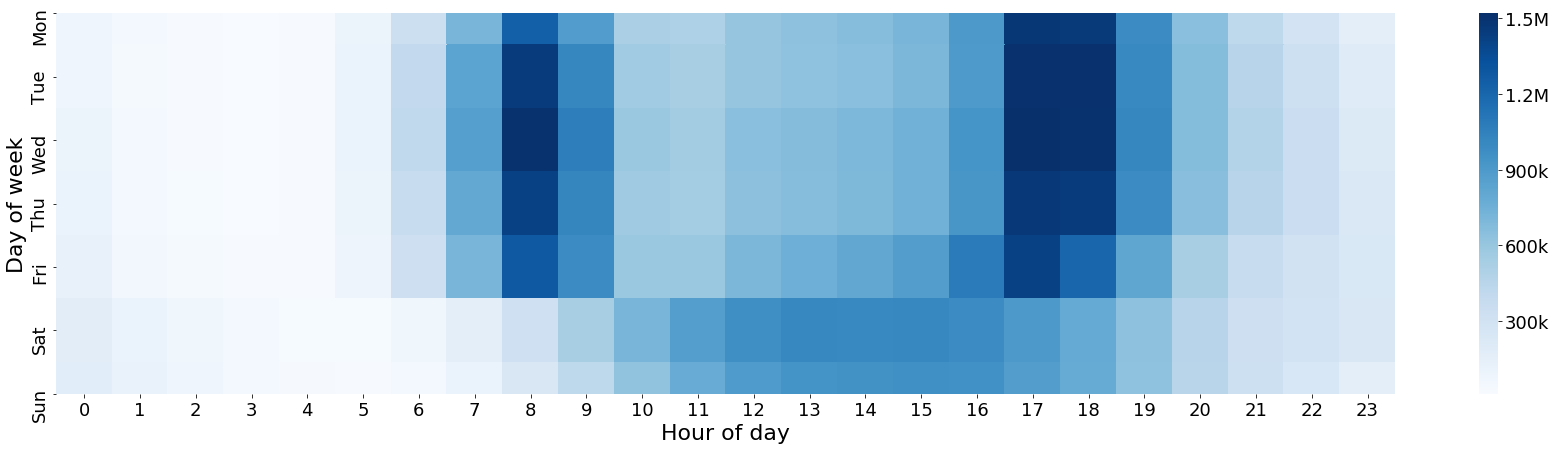

In [11]:
df_heat = df[['tripduration']]
df_heat['day_num'] = df.index.weekday
df_heat['day_name'] = df.index.weekday_name
df_heat['day_hour'] = df.index.hour

fig, ax = plt.subplots(figsize = (30, 7))

ax = sns.heatmap(df_heat.pivot_table(index = 'day_num', 
                                     columns = 'day_hour', 
                                     values = 'tripduration', 
                                     aggfunc = 'count'), 
                 cmap = 'Blues'
)

ax.set_xlabel('Hour of day', fontsize=22)
ax.set_ylabel('Day of week', fontsize=22)
ax.set_yticklabels(day_abbr[0:7])

cbar = ax.collections[0].colorbar
cbar.set_ticks([30000, 60000, 90000, 120000, 150000])

# df is downsampled 10x
cbar.set_ticklabels(['300k', '600k', '900k', '1.2M', '1.5M']);

# Going For a Bike Ride

#### We're defining two individuals as going for a bike ride if the following conditions are met:
- The two start and end at the same station
- The two start their trips within 30 seconds of eachother
- The two end their trips within 30 seconds of eachother

#### We'll also assess whether these are reasonable critera for concluding that riders are together

In [12]:
# loading in data - query for data can be seen in data_prep file
df_r = pd.read_csv('./data/initial/bike_rides.csv')

for col in ['a_start', 'b_start', 'a_stop', 'b_stop']:
    df_r[col] = pd.to_datetime(df_r[col], format = '%Y-%m-%d %H:%M')

df_r.set_index('a_start', inplace = True)

In [13]:
c = {'a_age' : 'a_yob', 'b_age' : 'b_yob'}

for col_new, col in c.items():
    df_r[col_new] = df_r.index.year - df_r[col] + 1

## Age and Gender Demos

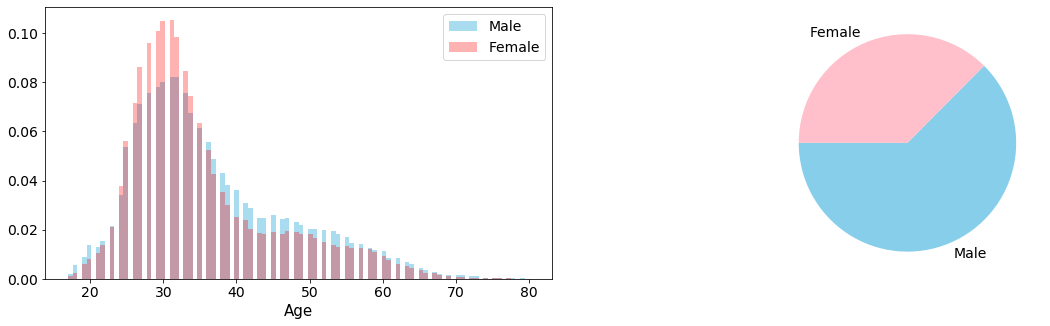

In [14]:
mask = (df_r.a_age <= 80) & (df_r.b_age <= 80)

a = df_r[mask][['a_age', 'a_gender']].rename(columns = {'a_age' : 'age','a_gender' :'gender'})
b = df_r[mask][['b_age', 'b_gender']].rename(columns = {'b_age' : 'age','b_gender' :'gender'})

dat = a.append(b)

# historgrams
m = dat[(dat['gender'] == 'male')]['age']
f = dat[(dat['gender'] == 'female')]['age']

plt.rcParams.update({'font.size': 14})

# figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 5))

ax1.hist(m, bins = 100, alpha = 0.7, color = 'skyblue', label = 'Male', density = True)
ax1.hist(f, bins = 100, alpha = 0.3, color = 'red', label = 'Female', density = True)
ax1.set_xlabel('Age', fontsize = 15)
ax1.legend(loc = 'upper right')

mask = (dat['gender'] != 'unknown')
ax2.pie(dat[mask].gender.value_counts(normalize = True),
        labels = ['Male', 'Female'],
        startangle = 180,
        colors = ['skyblue', 'pink']);

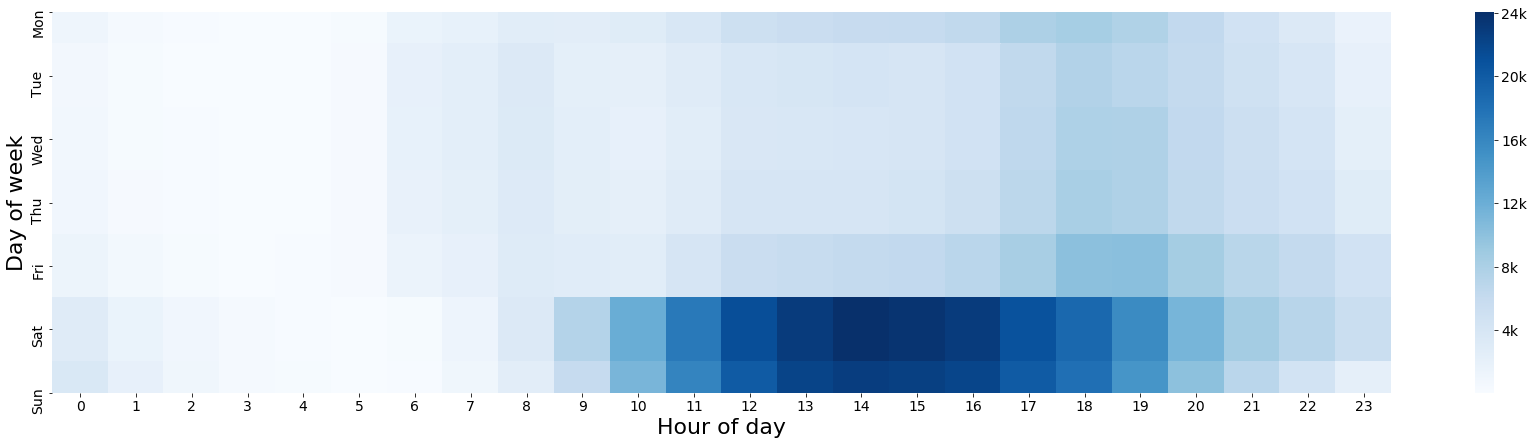

In [15]:
df_r['day_num'] = df_r.index.weekday
df_r['day_name'] = df_r.index.weekday_name
df_r['day_hour'] = df_r.index.hour

f, ax = plt.subplots(figsize = (30, 7))

ax = sns.heatmap(df_r.pivot_table(index = 'day_num', 
                                     columns = 'day_hour', 
                                     values = 'start_station_id', 
                                     aggfunc = 'count'), 
                 cmap = 'Blues'
)

ax.set_xlabel('Hour of day', fontsize=22)
ax.set_ylabel('Day of week', fontsize=22)
ax.set_yticklabels(day_abbr[0:7])

cbar = ax.collections[0].colorbar
cbar.set_ticks([4000, 8000, 12000, 16000, 20000, 24000])
cbar.set_ticklabels(['4k', '8k', '12k', '16k', '20k', '24k']);

In [16]:
mask = (df['age'] <= 80)

age_mean = df[mask].age.mean()
age_var = df[mask].age.var()
print('E[Age]: {:.0f}, Var(Age): {:.0f}'.format(age_mean, age_var))

E[Age]: 39, Var(Age): 136


# Are these riders together or are we observing a coincidence?
- One might expect that the two riders riding together would be friends, significant others, etc ... and would tend to be closer in age than two randomly chosen riders from our population

### Sampling pairs randomly from our population, we'd expect to see
- E[Age Differece] = E[X1 - X2] = E[X1] - E[X2] = 0
- Var[Age Difference] = Var[X1 - X2] = Var[X1] + Var[X2] = 272
- The above assumes a normal distribution which can certainly be debated

### We'll overlay the observed and expected distributions

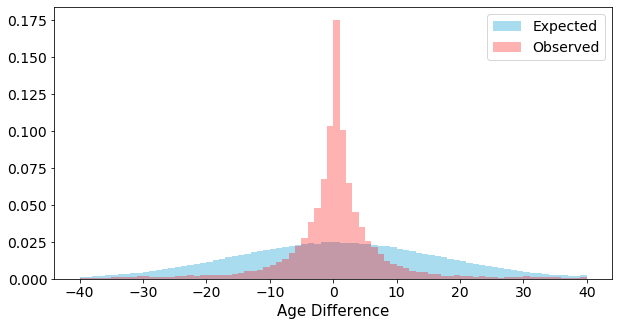

In [17]:
mask = (df_r.a_age <= 80) & (df_r.b_age <= 80) & (df_r.a_gender != 'unknown') & (df_r.b_age != 'unknown')

# expected and observed distributions
e = np.random.normal(age_mean - age_mean, np.sqrt(age_var + age_var), df_r.shape[0]).round()
o = df_r[mask].a_age - df_r[mask].b_age

# figure
fig, (ax1) = plt.subplots(1, 1, figsize = (10, 5))

ax1.hist(e, bins = 80, alpha = 0.7, range = [-40, 40], color = 'skyblue', label = 'Expected', density = True)
ax1.hist(o, bins = 80, alpha = 0.3, range = [-40, 40], color = 'red', label = 'Observed', density = True)
ax1.set_xlabel('Age Difference', fontsize = 15)
ax1.legend(loc = 'upper right');

- It appears that the age difference distribution in our Riders dataset has much smaller variance, and more tightly packed around zero, than the age difference distribution we'd see from randomly sampling pairs from our population

- It's possible that the ages are more tightly packed in our Riders dataset because the pairs are taking bikes from the same dock. Maybe we're only measuring the fact that these riders are likely from the same neighborhood, and perhaps ages tend to cluster within neighborhoods. 

- We'll now randomly sample pairs from the same dock from our overall dataset. The number of pairs sampled from each dock will be proportionate to each dock's representation in the dataset

In [18]:
# dock df
# pct = dock's represention in overall data
# sample_ct = # of pairs to sample from each dock

dock_rides = pd.DataFrame(df.start_station_id.value_counts())
dock_rides.rename(columns = {'start_station_id' : 'rides'}, inplace = True)

dock_rides['pct'] = df.start_station_id.value_counts(normalize = True)
dock_rides['sample_ct'] = np.ceil(dock_rides.pct * df_r.shape[0])

# filtering out docks with fewer than 50 rides 
mask = (dock_rides.rides > 50)
dock_rides = dock_rides[mask]

In [19]:
# sampling loop
# gender unknown was discovered to be assigned age = 50
# filtering out to remove a bias in number of age_diff = 0

mask = (df.age <= 80) & (df.gender != 'unknown')
samp_df = df[mask & (df.age.notnull())]
sample = []

j = 0

# mask = (dock_rides.sample_ct > 50)
for index in dock_rides.index:
    
    size = dock_rides.loc[index].sample_ct.astype(int)
    loop_df = samp_df[samp_df['start_station_id'] == index]
    i = 0
    while i in range(size):
        
        pair = np.random.choice(loop_df.age, size = 2, replace = True)
        sample.append(pair)

        i += 1
    j += 1
    
df_s = pd.DataFrame(sample)
df_s['diff'] = df_s[0] - df_s[1]

In [20]:
# checking that our sample is approx equal to our Riders dataset
display(df_r.shape[0], df_s.shape[0], df_s.shape[0] - df_r.shape[0])

912258

912556

298

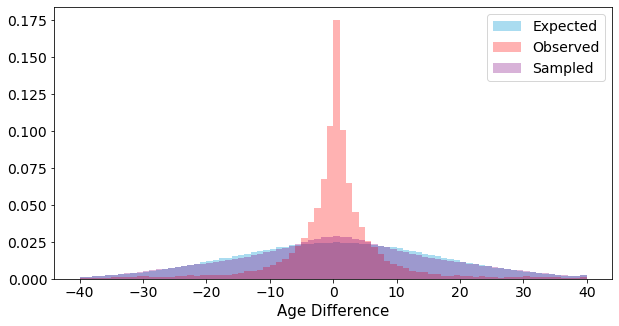

In [21]:
# adding our sampled dataset on our distributions visualization

mask = (df_r.a_age <= 80) & (df_r.b_age <= 80) & (df_r.a_gender != 'unknown') & (df_r.b_age != 'unknown')

# expected and observed distributions
e = np.random.normal(age_mean - age_mean, np.sqrt(age_var + age_var), df_r.shape[0]).round()
o = df_r[mask].a_age - df_r[mask].b_age

# figure
fig, (ax1) = plt.subplots(1, 1, figsize = (10, 5))

ax1.hist(e, bins = 80, alpha = 0.7, range = [-40, 40], color = 'skyblue', label = 'Expected', density = True)
ax1.hist(o, bins = 80, alpha = 0.3, range = [-40, 40], color = 'red', label = 'Observed', density = True)
ax1.hist(df_s['diff'], bins = 80, alpha = 0.3, range = [-40, 40], color = 'purple', label = 'Sampled', density = True);
ax1.set_xlabel('Age Difference', fontsize = 15)
ax1.legend(loc = 'upper right');

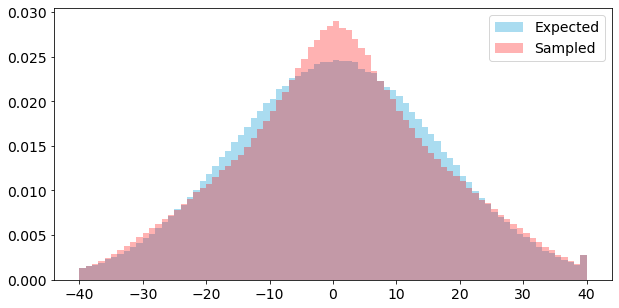

In [22]:
# full disclosure, the sampled dataset doesnt quite have a normal shape:
# I tried sampling without replacement, and filtering out docks with fewer rides overall
# to reduce the chance of having samples with the same rider (and thus same age) to correct the
# non-Gaussian shape but haven't quite cracked the code. 

# Either way, our sampled dataset is quite similar to the Expected dataset we've generated using theory

fig, (ax1) = plt.subplots(1, 1, figsize = (10, 5))

ax1.hist(e, bins = 80, alpha = 0.7, range = [-40, 40], color = 'skyblue', label = 'Expected', density = True)
ax1.hist(df_s['diff'], bins = 80, alpha = 0.3, range = [-40, 40], color = 'red', label = 'Sampled', density = True)
ax1.legend(loc = 'upper right');

# Time Series with Facebook Prophet

In [23]:
# loading / transforming weather data

df_w = pd.read_csv('./data/weather/weather.csv')
df_w.rename(columns = {'YR--MODAHRMN' : 'timestamp'}, inplace = True)

df_w['timestamp'] = pd.to_datetime(df_w['timestamp'], format='%Y%m%d%H%M')
df_w.set_index(df_w['timestamp'], inplace = True)
df_w.drop(columns = ['timestamp'], inplace = True)

# interested in the effects of temp, precip, wind, snow y/n
columns = ['TEMP', 'PCP01', 'PCP06', 'PCP24', 'SPD', 'GUS', 'SD']
df_w = df_w[columns]

df_w.head()

,TEMP,PCP01,PCP06,PCP24,SPD,GUS,SD
timestamp,,,,,,,
2012-04-01 00:51:00,43,*****,*****,*****,3,***,**
2012-04-01 01:51:00,43,*****,*****,*****,6,***,**
2012-04-01 02:51:00,43,*****,*****,*****,5,***,**
2012-04-01 03:00:00,34,*****,*****,*****,6,***,**
2012-04-01 03:51:00,43,*****,*****,*****,5,***,**


In [24]:
for col in df_w.columns:
    df_w[col] = df_w[col].apply(lambda x: x.replace('T ', '0'))
    df_w[col] = df_w[col].apply(lambda x: x.replace('T*****', '0'))
    df_w[col] = df_w[col].apply(lambda x: x.replace('T**', '0'))
    df_w[col] = df_w[col].apply(lambda x: x.replace('*****', '0'))
    df_w[col] = df_w[col].apply(lambda x: x.replace('****', '0'))
    df_w[col] = df_w[col].apply(lambda x: x.replace('***', '0'))
    df_w[col] = df_w[col].apply(lambda x: x.replace('**', '0'))
    df_w[col] = df_w[col].fillna(0)
    df_w[col] = df_w[col].astype('float')

In [25]:
df_w = df_w.groupby(pd.Grouper(freq = 'D')).mean().fillna(0)
df_w.reset_index(inplace = True)
df_w.rename(columns = {'timestamp' : 'ds'}, inplace = True)

In [27]:
df_fb = df[['bikeid']].groupby(pd.Grouper(freq = 'D')).count()
df_fb.reset_index(inplace = True)
df_fb.columns = ['ds', 'y']

In [28]:
df_ho = df_fb[df_fb['ds'] >= pd.Timestamp('2019-03-01')]
df_fb = df_fb[df_fb['ds'] <= pd.Timestamp('2019-02-28')]

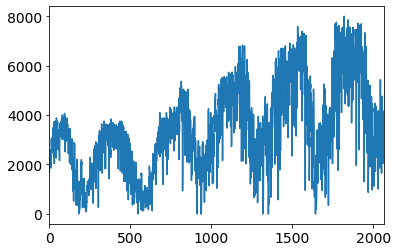

In [29]:
df_fb.y.plot(x = df_fb.ds)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2015-09-12 00:00:00 and 2018-02-28 00:00:00


RMSE : 863.3742079205904


<Figure size 432x288 with 0 Axes>

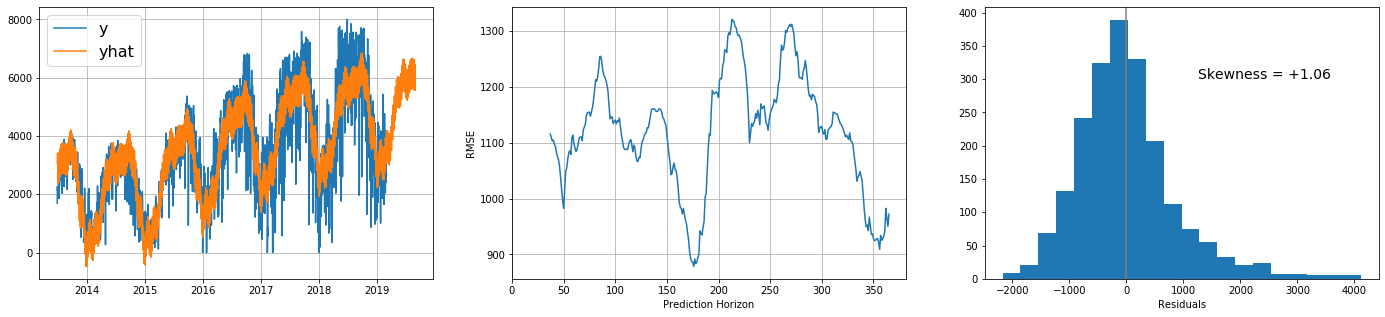

In [33]:
model = Prophet()
model.fit(df_fb)

df_cv = cross_validation(model, initial = '730 days', period = '180 days', horizon = '365 days')
df_p = performance_metrics(df_cv, metrics = ['rmse'])

future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

f.m_rmse(df_fb, forecast), f.charts(df_fb, df_p, forecast);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2015-09-12 00:00:00 and 2018-02-28 00:00:00


RMSE : 818.1861151702062


<Figure size 432x288 with 0 Axes>

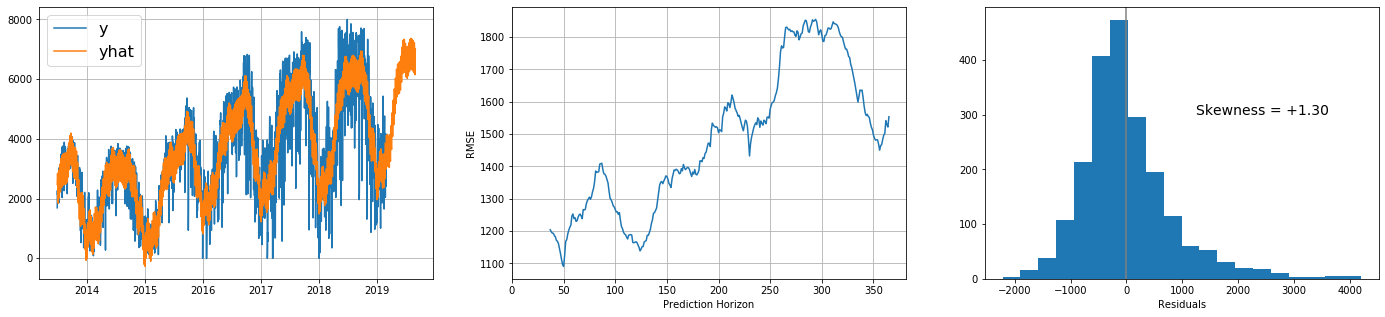

In [34]:
model = Prophet(changepoint_prior_scale = 2.5)
model.fit(df_fb)

df_cv = cross_validation(model, initial = '730 days', period = '180 days', horizon = '365 days')
df_p = performance_metrics(df_cv, metrics = ['rmse'])

future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

f.m_rmse(df_fb, forecast), f.charts(df_fb, df_p, forecast);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2015-09-12 00:00:00 and 2018-02-28 00:00:00


RMSE : 841.8257418956885


<Figure size 432x288 with 0 Axes>

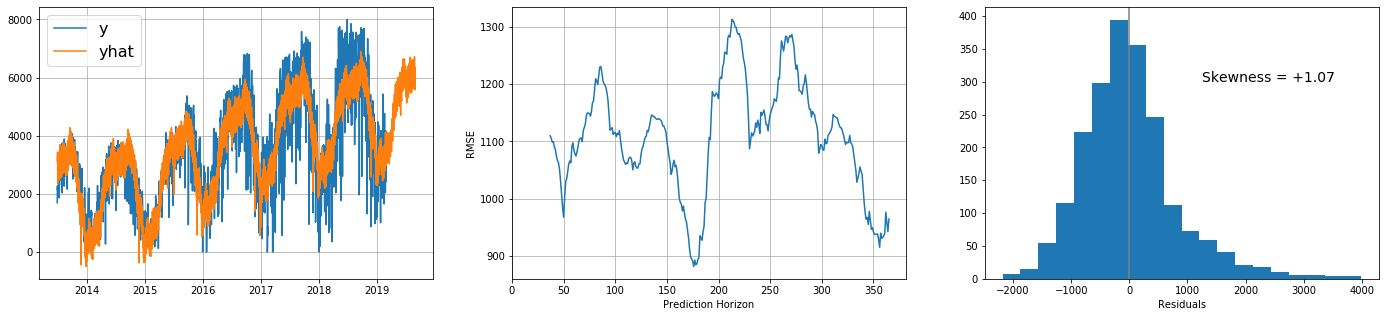

In [35]:
model = Prophet()
model.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model.add_country_holidays(country_name = 'US')
model.fit(df_fb)

df_cv = cross_validation(model, initial = '730 days', period = '180 days', horizon = '365 days')
df_p = performance_metrics(df_cv, metrics = ['rmse'])

future = model.make_future_dataframe(periods=180)
forecast = model.predict(future)

f.m_rmse(df_fb, forecast), f.charts(df_fb, df_p, forecast);

In [36]:
df_reg = df_fb.copy()
df_reg = df_reg.merge(df_w, on = 'ds', how = 'inner')
df_reg.head()

,ds,y,TEMP,PCP01,PCP06,PCP24,SPD,GUS,SD
0,2013-07-01,1691,71.586207,0.030690,0.028966,0.000000,2.655172,1.310345,0.0
1,2013-07-02,2268,72.480000,0.000400,0.000400,0.067200,2.200000,0.000000,0.0
2,2013-07-03,2127,73.321429,0.021429,0.021429,0.005714,3.571429,0.642857,0.0
3,2013-07-04,2203,76.400000,0.000000,0.000000,0.042400,2.720000,0.000000,0.0
4,2013-07-05,2247,79.080000,0.000000,0.000000,0.000000,4.240000,1.480000,0.0


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Making 6 forecasts with cutoffs between 2015-09-12 00:00:00 and 2018-02-28 00:00:00


RMSE : 573.1320098905094


<Figure size 432x288 with 0 Axes>

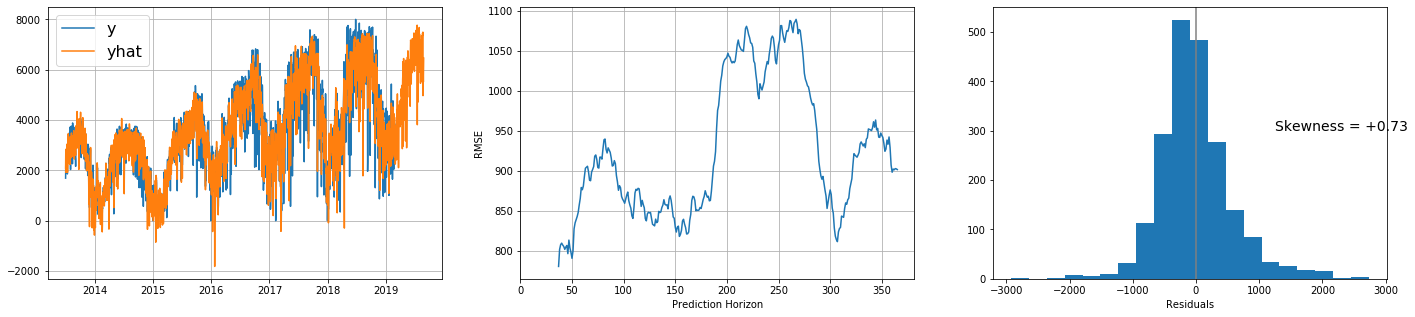

In [37]:
reg_prior = 5
reg_mode = 'multiplicative'

model = Prophet(changepoint_prior_scale = 2.5)
model.add_seasonality(name = 'monthly', period = 30.5, fourier_order = 5)
model.add_country_holidays(country_name = 'US')

model.add_regressor('TEMP', prior_scale = reg_prior, mode = reg_mode)
model.add_regressor('PCP01', prior_scale = reg_prior, mode = reg_mode)
model.add_regressor('SPD', prior_scale = reg_prior, mode = reg_mode)
model.add_regressor('SD', prior_scale = reg_prior, mode = reg_mode)

model.fit(df_reg)

df_cv = cross_validation(model, initial = '730 days', period = '180 days', horizon = '365 days')
df_p = performance_metrics(df_cv, metrics = ['rmse'])

future = model.make_future_dataframe(periods=180)
future = future.merge(df_w, on = 'ds', how = 'inner')

forecast = model.predict(future)

f.m_rmse(df_reg, forecast), f.charts(df_reg, df_p, forecast);

In [38]:
df_ho = df_ho.merge(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on = 'ds', how = 'inner')
ho_rmse = np.sqrt(np.mean((df_ho.yhat - df_ho.y) ** 2))

print(f'holdout set rmse:{ho_rmse}')

holdout set rmse:1191.9976444012411


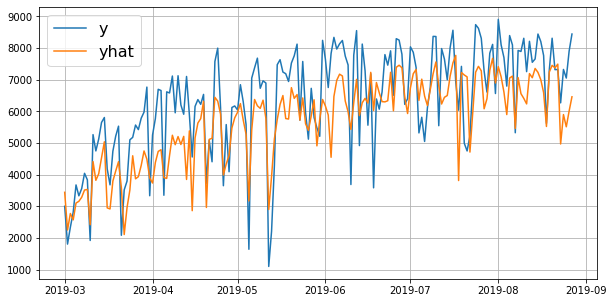

In [39]:
plt.figure(figsize = (10, 5))
plt.plot(df_ho.ds, df_ho.y, label = 'y')
plt.plot(df_ho.ds, df_ho.yhat, label = 'yhat')
plt.grid(True)
plt.legend(loc = 'upper left', fancybox = True, prop = {'size' : 16})

### Future Learnings:

- How to correct for seasonality in RMSE

# Commuters
- Future work: Update below map to highlight where commuters are traveling to / from with slider for time of day

In [54]:
com_df = pd.read_csv('./data/initial/commuters.csv')

# Dictionary of important locations in New York
list_of_locations = {
    "Madison Square Garden": {"lat": 40.7505, "lon": -73.9934},
    "Yankee Stadium": {"lat": 40.8296, "lon": -73.9262},
    "Empire State Building": {"lat": 40.7484, "lon": -73.9857},
    "New York Stock Exchange": {"lat": 40.7069, "lon": -74.0113},
    "JFK Airport": {"lat": 40.644987, "lon": -73.785607},
    "Grand Central Station": {"lat": 40.7527, "lon": -73.9772},
    "Times Square": {"lat": 40.7589, "lon": -73.9851},
    "Columbia University": {"lat": 40.8075, "lon": -73.9626},
    "United Nations HQ": {"lat": 40.7489, "lon": -73.9680},
}

# chart defaults

zoom = 11.0
latInitial = 40.7272
lonInitial = -73.991251
bearing = 0

# creating chart_df

sample_df = com_df.sample(frac = 0.1)
leave_home = sample_df[['depart_home', 'start_station_latitude', 'start_station_longitude']]
leave_home['event'] = 'leave_home'
leave_home['id'] = sample_df.index
leave_home = leave_home.rename(columns = {'depart_home' : 'timestamp', 'start_station_latitude' : 'lat', 'start_station_longitude' : 'lon'})

arrive_work = sample_df[['arrive_work', 'end_station_latitude', 'end_station_longitude']]
arrive_work['event'] = 'arrive_work'
arrive_work['id'] = sample_df.index
arrive_work = arrive_work.rename(columns = {'arrive_work' : 'timestamp', 'end_station_latitude' : 'lat', 'end_station_longitude' : 'lon'})

leave_work = sample_df[['depart_work', 'end_station_latitude', 'end_station_longitude']]
leave_work['event'] = 'leave_work'
leave_work['id'] = sample_df.index
leave_work = leave_work.rename(columns = {'depart_work' : 'timestamp', 'end_station_latitude' : 'lat', 'end_station_longitude' : 'lon'})

arrive_home = sample_df[['arrive_home', 'start_station_latitude', 'start_station_longitude']]
arrive_home['event'] = 'arrive_home'
arrive_home['id'] = sample_df.index
arrive_home = arrive_home.rename(columns = {'arrive_home' : 'timestamp', 'start_station_latitude' : 'lat', 'start_station_longitude' : 'lon'})

chart_df = pd.concat([leave_home, arrive_work, leave_work, arrive_home], axis = 0)
columns = ['timestamp', 'id', 'event', 'lat', 'lon']

chart_df = chart_df[columns]
chart_df['timestamp'] = pd.to_datetime(chart_df['timestamp'], format="%Y-%m-%d %H:%M")
chart_df = chart_df.set_index('timestamp')

# confirming chart_df dim
# display(chart_df.shape[0] == sample_df.shape[0] * 4)
# chart_df.head()

tst_mask = (chart_df['event'] == 'leave_home') & (chart_df.index.year == 2013)
tst_df = chart_df[tst_mask]

def map(year):

    tst_mask = (chart_df['event'] == 'leave_home') & (chart_df.index.year == year)
    tst_df = chart_df[tst_mask]

    fig = go.Figure(
        data = [
    #         Data for all rides based on date and time
            Scattermapbox(
                lat = tst_df['lat'],
                lon = tst_df['lon'],
                mode = 'markers',
                marker = dict(
                    showscale = True,
    #                 color = np.append(np.insert(listCoords.index.hour, 0 , 0), 23),
                    opacity = 0.5,
                    size = 5,
                    colorscale = [                
                        [0, "#F4EC15"],
                        [0.04167, "#DAF017"],
                        [0.0833, "#BBEC19"],
                        [0.125, "#9DE81B"],
                        [0.1667, "#80E41D"],
                        [0.2083, "#66E01F"],
                        [0.25, "#4CDC20"],
                        [0.292, "#34D822"],
                        [0.333, "#24D249"],
                        [0.375, "#25D042"],
                        [0.4167, "#26CC58"],
                        [0.4583, "#28C86D"],
                        [0.50, "#29C481"],
                        [0.54167, "#2AC093"],
                        [0.5833, "#2BBCA4"],
                        [1.0, "#613099"],
                    ],
    #                 colorbar = dict(
    #                         title="Time of<br>Day",
    #                         x=0.93,
    #                         xpad=0,
    #                         nticks=24,
    #                         tickfont=dict(color="#d8d8d8"),
    #                         titlefont=dict(color="#d8d8d8"),
    #                         thicknessmode="pixels",                    
    #                 ),
                ),
            ),
            # Plot of important locations on the map
            Scattermapbox(
                lat=[list_of_locations[i]["lat"] for i in list_of_locations],
                lon=[list_of_locations[i]["lon"] for i in list_of_locations],
                mode="markers",
                hoverinfo="text",
                text=[i for i in list_of_locations],
                marker=dict(size=8, color="#ffa0a0"),
            ),        
        ],
        layout=Layout(
            autosize=True,
            margin=go.layout.Margin(l=0, r=35, t=0, b=0),
            showlegend=False,
            mapbox=dict(
                accesstoken=mapbox_access_token,
                center=dict(lat=latInitial, lon=lonInitial),  # 40.7272  # -73.991251
                style="dark",
                bearing=bearing,
                zoom=zoom,
            ),
            updatemenus=[
                dict(
                    buttons=(
                        [
                            dict(
                                args=[
                                    {
                                        "mapbox.zoom": 12,
                                        "mapbox.center.lon": "-73.991251",
                                        "mapbox.center.lat": "40.7272",
                                        "mapbox.bearing": 0,
                                        "mapbox.style": "dark",
                                    }
                                ],
                                label="Reset Zoom",
                                method="relayout",
                            )
                        ]
                    ),
                    direction="left",
                    pad={"r": 0, "t": 0, "b": 0, "l": 0},
                    showactive=False,
                    type="buttons",
                    x=0.45,
                    y=0.02,
                    xanchor="left",
                    yanchor="bottom",
                    bgcolor="#323130",
                    borderwidth=1,
                    bordercolor="#6d6d6d",
                    font=dict(color="#FFFFFF"),
                )
            ],
        ),
    )
    fig.update_layout(
        autosize = False,
        width = 1100,
        height = 700
    )

    fig.show()

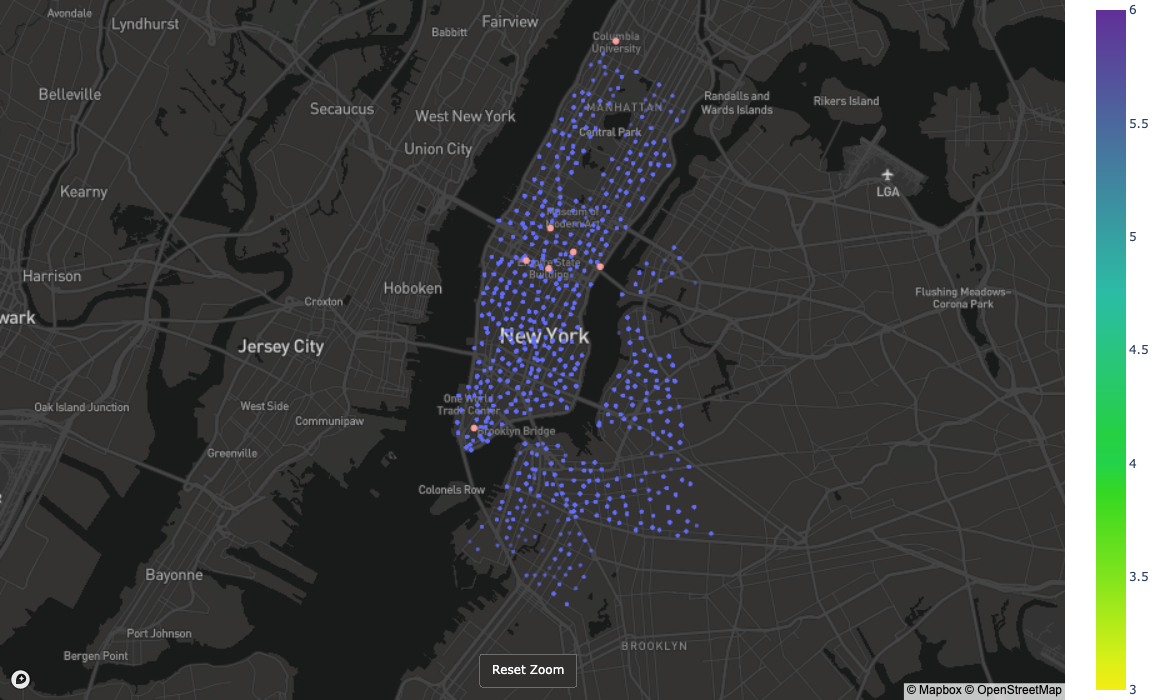

In [55]:
map(2016)